## Data Analysis on Arrests and Strip Searches
### Link: https://colab.research.google.com/drive/1w04ei9yXOqbifmhVXmg8lrQH06nxb33e?usp=sharing

In [203]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.stats.power as smp
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from tabulate import tabulate
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split



In [204]:
# import file
from google.colab import files
uploaded = files.upload()

Saving Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv to Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001) (3).csv


## Data Pre-processing

Data Cleaning

In [205]:
# import the csv file
df = pd.read_csv('Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv')
nullcols = df.columns[df.isnull().any()]

In [206]:
# check if there any missing values in the dataset
for column in df:
    print("{}\t\t\t\t{}".format(column, sum(df[column].isna())))

Arrest_Year				0
Arrest_Month				0
EventID				0
ArrestID				469
PersonID				0
Perceived_Race				4
Sex				0
Age_group__at_arrest_				24
Youth_at_arrest__under_18_years				0
ArrestLocDiv				0
StripSearch				0
Booked				0
Occurrence_Category				165
Actions_at_arrest___Concealed_i				0
Actions_at_arrest___Combative__				0
Actions_at_arrest___Resisted__d				0
Actions_at_arrest___Mental_inst				0
Actions_at_arrest___Assaulted_o				0
Actions_at_arrest___Cooperative				0
SearchReason_CauseInjury				57475
SearchReason_AssistEscape				57475
SearchReason_PossessWeapons				57475
SearchReason_PossessEvidence				57475
ItemsFound				57475
ObjectId				0


In [207]:
df.head()

,Arrest_Year,Arrest_Month,EventID,ArrestID,PersonID,Perceived_Race,Sex,Age_group__at_arrest_,Youth_at_arrest__under_18_years,ArrestLocDiv,...,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative,SearchReason_CauseInjury,SearchReason_AssistEscape,SearchReason_PossessWeapons,SearchReason_PossessEvidence,ItemsFound,ObjectId
0,2020,July-Sept,1005907,6017884.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,1
1,2020,July-Sept,1014562,6056669.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,2
2,2020,Oct-Dec,1029922,6057065.0,326622,Unknown or Legacy,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,3
3,2021,Jan-Mar,1052190,6029059.0,327535,Black,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4
4,2021,Jan-Mar,1015512,6040372.0,327535,South Asian,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,5


In [208]:
# remove all the nan values in ['ArrestID', 'Perceived_Race', 'Age_group__at_arrest_', 'Occurrence_Category']
# for 'searchreason', we fill nan value with 0 
df = df.dropna(subset = ['ArrestID', 'Perceived_Race', 'Age_group__at_arrest_', 'Occurrence_Category'])
df = df.fillna(0)

In [209]:
# check missing values in the dataset one more time
for column in df:
    print("{}\t\t\t\t{}".format(column, sum(df[column].isna())))

Arrest_Year				0
Arrest_Month				0
EventID				0
ArrestID				0
PersonID				0
Perceived_Race				0
Sex				0
Age_group__at_arrest_				0
Youth_at_arrest__under_18_years				0
ArrestLocDiv				0
StripSearch				0
Booked				0
Occurrence_Category				0
Actions_at_arrest___Concealed_i				0
Actions_at_arrest___Combative__				0
Actions_at_arrest___Resisted__d				0
Actions_at_arrest___Mental_inst				0
Actions_at_arrest___Assaulted_o				0
Actions_at_arrest___Cooperative				0
SearchReason_CauseInjury				0
SearchReason_AssistEscape				0
SearchReason_PossessWeapons				0
SearchReason_PossessEvidence				0
ItemsFound				0
ObjectId				0


In [210]:
# We need the number of arrest for each quarter of the past two years
# Assign a label to these eight quarters.
df["Quarter"] = np.where(
    (df["Arrest_Year"] == 2020) & (df["Arrest_Month"] == "Jan-Mar"), 1,
    (np.where(
        (df["Arrest_Year"] == 2020) & (df["Arrest_Month"] == "Apr-June"), 2,
        (np.where((df["Arrest_Year"] == 2020) &
                  (df["Arrest_Month"] == "July-Sept"), 3, (np.where(
                      (df["Arrest_Year"] == 2020) &
                      (df["Arrest_Month"] == "Oct-Dec"), 4, (np.where(
                          (df["Arrest_Year"] == 2021) &
                          (df["Arrest_Month"] == "Jan-Mar"), 5, (np.where(
                              (df["Arrest_Year"] == 2021) &
                              (df["Arrest_Month"] == "Apr-June"), 6, (np.where(
                                  (df["Arrest_Year"] == 2021) &
                                  (df["Arrest_Month"] == "July-Sept"), 7,
                                  (np.where((df["Arrest_Year"] == 2021) &
                                            (df["Arrest_Month"] == "Oct-Dec"),
                                            8, 0)))))))))))))))

In [211]:
# check 'Occurrence_Category'
df['Occurrence_Category'].unique()

array(['Assault & Other crimes against persons', 'Harassment/Threatening',
       'FTA/FTC/Compliance Check/Parollee', 'Assault', 'Robbery/Theft',
       'Sexual Related Crime', 'Mischief & Fraud', 'Warrant',
       'Police Category - Administrative',
       'FTA/FTC, Compliance Check & Parollee', 'Drug Related', 'Weapons',
       'Vehicle Related (inc. Impaired)', 'Other Offence',
       'Harassment & Threatening', 'Weapons & Homicide',
       'Robbery & Theft', 'Break and Enter', 'Mischief', 'Break & Enter',
       'Sexual Related Crimes & Crimes Against Children',
       'Crimes against Children', 'Police Category - Incident', 'Fraud',
       'LLA', 'Mental Health', 'Other Statute', 'Vehicle Related',
       'Other Statute & Other Incident Type', 'Impaired', 'Homicide'],
      dtype=object)

In [212]:
# classify the 'Occurrence_Category'
display_List = {
    "Assault & Other crimes against persons": "assault",
    "Assault": "assault",
    "Mischief & Fraud": "mischief",
    "Mischief & Fraud": "mischief",
    "Mischief": "mischief",
    "Fraud": "mischief",
    "FTA/FTC/Compliance Check/Parollee": "fta",
    "FTA/FTC, Compliance Check & Parollee": "fta",
    "Robbery/Theft": "robbery",
    "Robbery & Theft": "robbery",
    "Sexual Related Crime": "sexual and children",
    "Sexual Related Crimes & Crimes Against Children": "sexual and children",
    "Crimes against Children": "sexual and children",
    "Warrant": "warrant",
    "Police Category - Administrative": "police",
    "Police Category - Incident": "police",
    "Drug Related": "drug",
    "Weapons": "weapons and homicide",
    "Weapons & Homicide": "weapons and homicide",
    "Homicide": "weapons and homicide",
    "Vehicle Related (inc. Impaired)": "vehicle",
    "Vehicle Related": "vehicle",
    "Harassment & Threatening": "harassment",
    "Harassment/Threatening": "harassment",
    "Break and Enter": "break",
    "Break & Enter": "break",
    "Impaired": "impaired",
    "Mental Health": "other",
    "Other Offence": "other",
    "Other Statute": "other",
    "Other Statute & Other Incident Type": "other"
}

df['Occurrence_Category'] = df['Occurrence_Category'].replace(display_List)

df['Occurrence_Category'].unique()

array(['assault', 'harassment', 'fta', 'robbery', 'sexual and children',
       'mischief', 'warrant', 'police', 'drug', 'weapons and homicide',
       'vehicle', 'other', 'break', 'LLA', 'impaired'], dtype=object)

## Exploratory Data Analysis

### Sex and Arrest

In [213]:
# select columns and group data
sub = df[['Arrest_Year', 'Arrest_Month', 'Sex', 'StripSearch', 'ObjectId']]
sexsub = sub.groupby(['Arrest_Year', 'Arrest_Month',
                    'Sex']).agg({'ObjectId': 'count'})
sexsub = sexsub.reset_index()

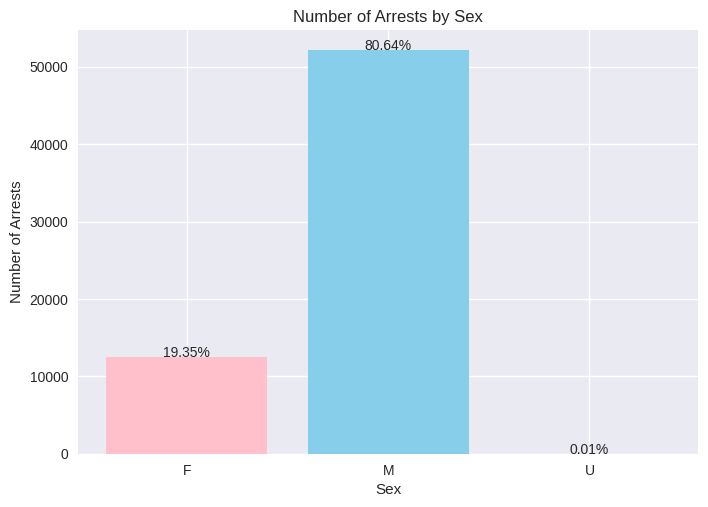

In [214]:
# Group the data by sex and sum the arrest counts
arrests_by_sex = sexsub.groupby(['Sex']).sum()['ObjectId']

# Calculate the total number of arrests
total_arrests = arrests_by_sex.sum()

# Calculate the percentage of arrests for each sex
percent_arrests_by_sex = 100 * arrests_by_sex / total_arrests

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(arrests_by_sex.index,
       arrests_by_sex.values,
       color=['pink', 'skyblue', 'gray'])
# Set the axis labels and title
ax.set_xlabel('Sex')
ax.set_ylabel('Number of Arrests')
ax.set_title('Number of Arrests by Sex')
# Show the percentages on the bars
for i, v in enumerate(arrests_by_sex.values):
    ax.text(i,
            v + 1,
            str(round(percent_arrests_by_sex[i], 2)) + '%',
            ha='center')
plt.show()

As shown, 80.64% of the arrested individuals were male, 19.35% were female, and the unknown sex group accounted for only 0.01%.

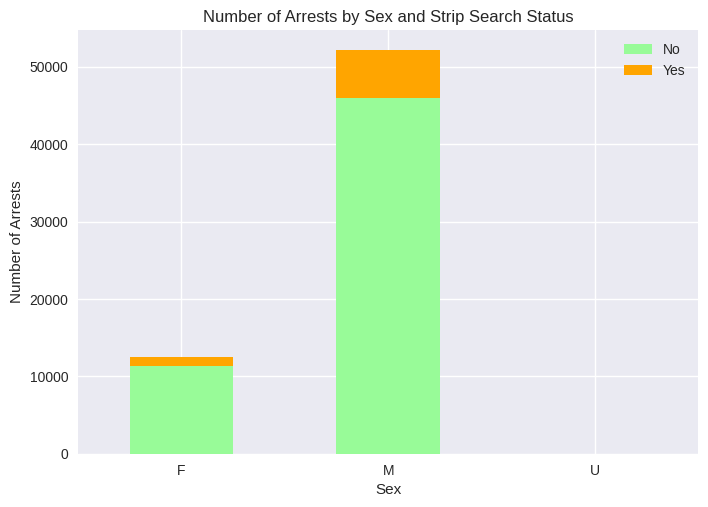

In [215]:
# Filter the dataframe to include only rows with male, female, or unknown sex
subsex = df[(df['Sex'] == 'M') | (df['Sex'] == 'F') | (df['Sex'] == 'U')]

# Group the data by sex and strip search status
substrip = subsex.groupby(['Sex', 'StripSearch']).agg({'ObjectId': 'count'})

# Reshape the data to create a stacked bar chart
substrip = substrip.unstack('StripSearch')

# Create a stacked bar chart with 2 colors
colors = ['palegreen', 'orange']
substrip.plot(kind='bar', stacked=True, color=colors)

# Set the axis labels and title
plt.xlabel('Sex')
plt.ylabel('Number of Arrests')
plt.title('Number of Arrests by Sex and Strip Search Status')

# Set the legend labels
leg_labels = ['No', 'Yes']
plt.legend(leg_labels, loc='upper right')

# Set the y-axis label orientation to horizontal
plt.xticks(rotation=0)

# Show the plot
plt.show()

The chart provides an overview of the number of arrests based on the sex and strip search status. While the male arrestee population may be five times larger than the female arrestee population, the data in this plot suggests that males are strip searched more frequently than females, and by a larger margin than what might be expected based on population size alone. 

### Perceived Races and Number of Arrests

In [216]:
# display the selected columns
racesub=df[['Arrest_Year','Arrest_Month','ObjectId','Perceived_Race','StripSearch','Actions_at_arrest___Combative__','Actions_at_arrest___Cooperative']].dropna()
racesub

,Arrest_Year,Arrest_Month,ObjectId,Perceived_Race,StripSearch,Actions_at_arrest___Combative__,Actions_at_arrest___Cooperative
0,2020,July-Sept,1,White,0,0,1
1,2020,July-Sept,2,White,0,0,0
2,2020,Oct-Dec,3,Unknown or Legacy,0,0,0
3,2021,Jan-Mar,4,Black,0,0,0
4,2021,Jan-Mar,5,South Asian,0,0,0
...,...,...,...,...,...,...,...
65271,2021,Oct-Dec,65272,Indigenous,0,0,0
65272,2021,Oct-Dec,65273,South Asian,0,0,0
65273,2021,Oct-Dec,65274,White,0,0,0
65274,2021,Oct-Dec,65275,Unknown or Legacy,0,0,1


In [217]:
racec = racesub.groupby(['Arrest_Year','Arrest_Month','Actions_at_arrest___Cooperative','Perceived_Race']).agg({'ObjectId': 'count'}).reset_index()
racec

,Arrest_Year,Arrest_Month,Actions_at_arrest___Cooperative,Perceived_Race,ObjectId
0,2020,Apr-June,0,Black,1063
1,2020,Apr-June,0,East/Southeast Asian,197
2,2020,Apr-June,0,Indigenous,128
3,2020,Apr-June,0,Latino,73
4,2020,Apr-June,0,Middle-Eastern,184
...,...,...,...,...,...
123,2021,Oct-Dec,1,Latino,138
124,2021,Oct-Dec,1,Middle-Eastern,214
125,2021,Oct-Dec,1,South Asian,229
126,2021,Oct-Dec,1,Unknown or Legacy,252


In [218]:
# group arrests people by perceived race
races_people = df.Perceived_Race.value_counts().index.tolist()
race_number = df.Perceived_Race.value_counts()
print(race_number)

White                   27407
Black                   17352
Unknown or Legacy        5002
East/Southeast Asian     4388
South Asian              3594
Middle-Eastern           3213
Indigenous               1907
Latino                   1752
Name: Perceived_Race, dtype: int64


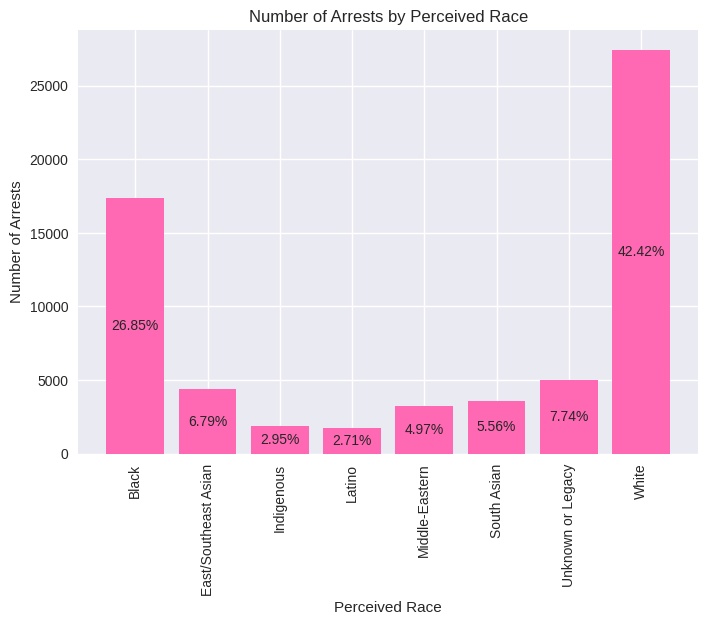

In [219]:
racetotal = racec.groupby('Perceived_Race')['ObjectId'].sum().reset_index()
fig, ax = plt.subplots()

# create the bar chart
ax.bar(racetotal['Perceived_Race'], racetotal['ObjectId'], color='hotpink')
ax.set_xlabel('Perceived Race')
ax.set_ylabel('Number of Arrests')
ax.set_title('Number of Arrests by Perceived Race')

# add percentage values to the bar chart
total = racetotal['ObjectId'].sum()
offset = 0
for i, v in enumerate(racetotal['ObjectId']):
    percentage = round((v/total)*100, 2)
    x_pos = i + offset
    y_pos = v/2
    ax.text(x_pos, y_pos, str(percentage)+'%', ha='center', va='center', fontsize=10)

# rotate the x-axis labels by 90 degrees
ax.set_xticklabels(racetotal['Perceived_Race'], rotation=90)

plt.show()


The bar chart illustrates the racial breakdown of arrests, with White individuals accounting for the largest percentage at 42.42%, followed by Black individuals at 26.85%. The percentage of arrests for Latino individuals is the lowest among the groups represented in the chart, at 2.71%.

### Perceived Races, Action at Arrest (Cooperative) and Number of Arrests

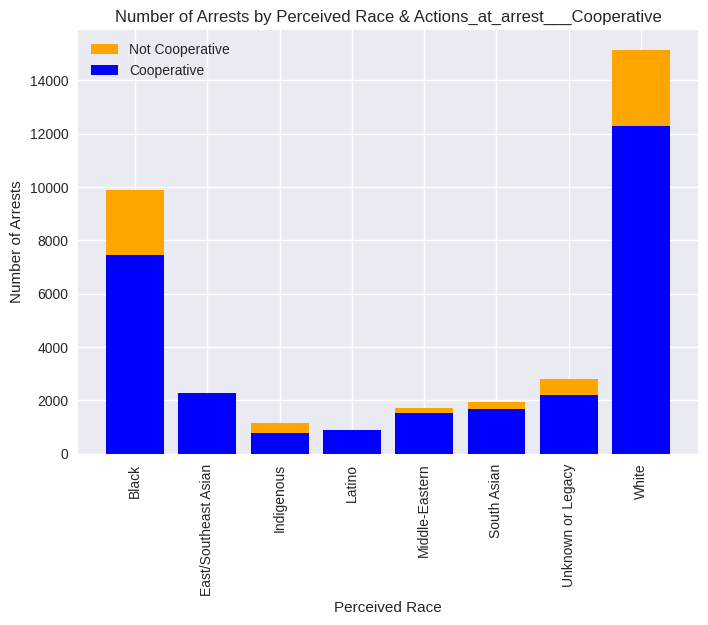

In [220]:
# group arrests people by perceived race
agg_df = racec.groupby(['Perceived_Race', 'Actions_at_arrest___Cooperative']).sum()['ObjectId'].unstack().reset_index()

# plot the bar chart
fig, ax = plt.subplots()
ax.bar(agg_df['Perceived_Race'], agg_df[0], color='orange', label='Not Cooperative')
ax.bar(agg_df['Perceived_Race'], agg_df[1], color='blue', label='Cooperative')
ax.set_xlabel('Perceived Race')
ax.set_ylabel('Number of Arrests')
ax.set_title('Number of Arrests by Perceived Race & Actions_at_arrest___Cooperative')
ax.legend()
# rotate the x-axis labels by 90 degrees
ax.set_xticklabels(racetotal['Perceived_Race'], rotation=90)
plt.show()

This plot shows the total number of arrests by perceived race, grouped by whether the individual cooperated or not. While White individuals account for approximately 10,000 more arrests than Black individuals, the proportion of non-cooperative individuals within each group is roughly similar. To explore this further, we have created a table that shows the number of cooperative arrests and cooperative percentage for each racial group, which will provide additional insight into the patterns observed in the plot.

In [221]:
# group cooperative or not ordered for arrested people by perceived race
race_coop = df.groupby('Perceived_Race').agg({'Actions_at_arrest___Cooperative': 'sum', 'ObjectId': 'count'})
race_coop_percent = (race_coop['Actions_at_arrest___Cooperative'] / race_coop['ObjectId']) * 100

# create a table to display the results
race_coop_table = pd.concat([race_coop['ObjectId'], race_coop['Actions_at_arrest___Cooperative'], race_coop_percent], axis=1, sort=False)
race_coop_table.columns = ['Total Arrests', 'Actions_at_arrest___Cooperative', 'Actions_at_arrest___Cooperative %']
race_coop_table.index.name = 'Perceived Race'
race_coop_table = race_coop_table.round(2)

race_coop_table

,Total Arrests,Actions_at_arrest___Cooperative,Actions_at_arrest___Cooperative %
Perceived Race,,,
Black,17352,7453,42.95
East/Southeast Asian,4388,2267,51.66
Indigenous,1907,758,39.75
Latino,1752,892,50.91
Middle-Eastern,3213,1509,46.97
South Asian,3594,1662,46.24
Unknown or Legacy,5002,2214,44.26
White,27407,12283,44.82


According to the table, there were 17,352 arrests of individuals perceived as Black, and of those arrests, 7,453 (42.95%) were cooperative. Similarly, there were 27,407 arrests of individuals perceived as White, and of those arrests, 12,283 (44.82%) were cooperative.
East/Southeast Asian (51.66%) and Latino (50.91%) individuals appear to have a slightly higher proportion of cooperative arrests than other groups, while Indigenous individuals have a lower proportion (42.95%).


### Booked, Perceived Races and Number of Arrests

In [222]:
# group book or not ordered for arrested people by perceived race
race_book = df.groupby('Perceived_Race').agg({'Booked': 'sum', 'ObjectId': 'count'})
race_book_percent = (race_book['Booked'] / race_book['ObjectId']) * 100

# create a table to display the results
race_book_table = pd.concat([race_book['ObjectId'], race_book['Booked'], race_book_percent], axis=1, sort=False)
race_book_table.columns = ['Total Arrests', 'Booked', 'Booked %']
race_book_table.index.name = 'Perceived Race'
race_book_table = race_book_table.round(2)

race_book_table

,Total Arrests,Booked,Booked %
Perceived Race,,,
Black,17352,9666,55.71
East/Southeast Asian,4388,2094,47.72
Indigenous,1907,1071,56.16
Latino,1752,964,55.02
Middle-Eastern,3213,1630,50.73
South Asian,3594,1776,49.42
Unknown or Legacy,5002,2435,48.68
White,27407,14247,51.98


This table shows the number of arrests and the proportion of arrests resulting in booking for each perceived race category. Overall, the table suggests that Indigenous (56.16%) and Black (55.71%) individuals are slightly more likely to be booked following an arrest than other groups, while East/Southeast Asian (47.72%) and South Asian (49.42%) individuals are slightly less likely. 

In [223]:
# Select only the columns we need for our analysis
sub = df[['Arrest_Year','Arrest_Month','Perceived_Race', 'Booked','Sex','ObjectId']]

# Group the data by year, month, and perceived race, and calculate the count of ObjectIds (arrests) and the sum of Booked (booked arrests)
aggsub=sub.groupby(['Arrest_Year','Arrest_Month','Perceived_Race']).agg({'ObjectId': 'count','Booked': 'sum'}).reset_index()
aggsub

,Arrest_Year,Arrest_Month,Perceived_Race,ObjectId,Booked
0,2020,Apr-June,Black,1803,952
1,2020,Apr-June,East/Southeast Asian,423,208
2,2020,Apr-June,Indigenous,196,109
3,2020,Apr-June,Latino,170,90
4,2020,Apr-June,Middle-Eastern,339,156
...,...,...,...,...,...
59,2021,Oct-Dec,Latino,261,135
60,2021,Oct-Dec,Middle-Eastern,462,233
61,2021,Oct-Dec,South Asian,488,232
62,2021,Oct-Dec,Unknown or Legacy,561,255


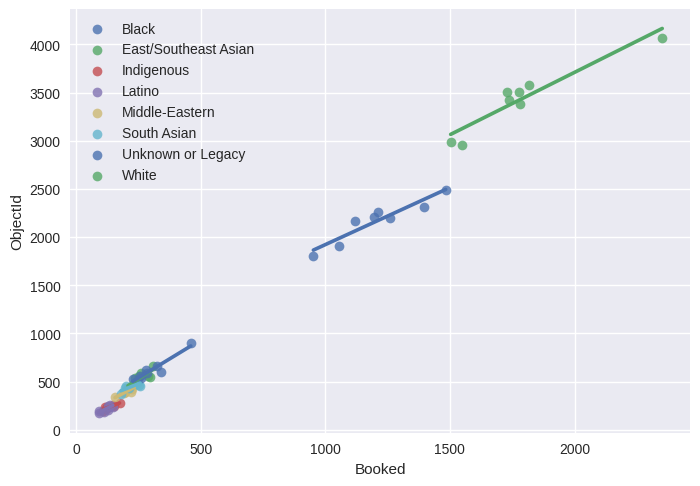

In [224]:
# Get the unique perceived race categories from the aggregated DataFrame
races = aggsub['Perceived_Race'].unique()

# Iterate over each perceived race category and plot a regression line of booked arrests against total arrests for that category
fig, ax = plt.subplots()

for race in races:
    race_data = aggsub[aggsub['Perceived_Race'] == race]
    sns.regplot(x="Booked", y="ObjectId", data=race_data, label=race, ci=None)

ax.legend()
plt.show()

The scatterplot with regression lines for each perceived race category shows a clear linear relationship between the number of booked strip searches and the total number of arrests. Each race category is represented by a different regression line, with all lines showing a positive slope and a statistically significant relationship between the two variables. 

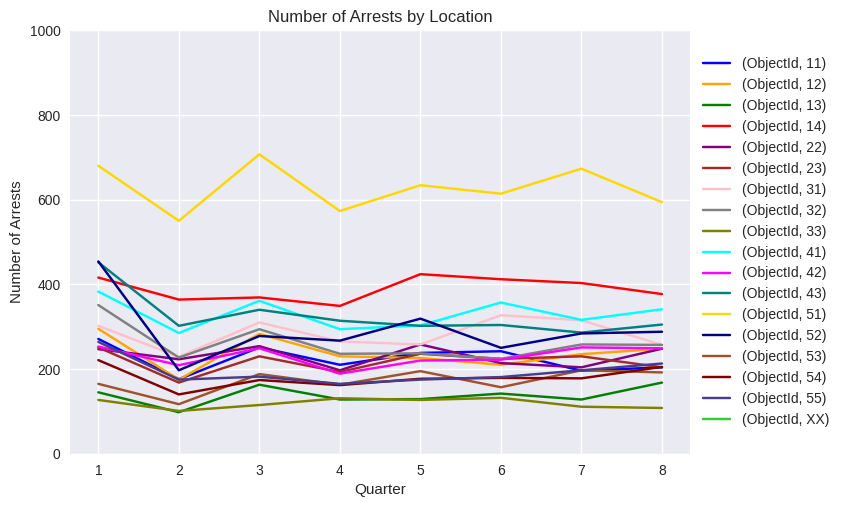

In [225]:
# Group the DataFrame by quarter and ArrestLocDiv, and count the number of observations in each group
new_df = df.groupby(['Quarter', 'ArrestLocDiv']).count()[['ObjectId']]
new_df = new_df.unstack(level=1)

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'teal', 'gold', 'navy', 'sienna', 'maroon', 'darkslateblue', 'limegreen']
# Create a line plot of the number of arrests by location over time
ax = new_df.plot(kind='line', color=colors)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Add axis labels and a title to the plot
plt.xlabel('Quarter')
plt.ylabel('Number of Arrests')
plt.title('Number of Arrests by Location')
plt.ylim(0, 1000) # Focus on different ArrestLocDiv
plt.show()


The plot shows the number of arrests by arrest location for each quarter from 2020 to 2021. Each line represents a different arrest location, and the colour of each line is unique. The y-axis shows the number of arrests, and the x-axis represents the quarters of the two years.
It is clear from the plot that Loc51 has the highest number of arrests compared to other arrest locations. Additionally, we can see that the number of arrests fluctuates throughout the quarters, with some quarters having higher arrest rates than others.

## T-test

### T-test #1: Number of Arrests Male vs Female

H0 (Null Hypothesis): The mean number of arrests among sex groups is equal.

Ha (Alternative Hypothesis): The mean number of arrests among sex groups is not equal.

In [226]:
# Create separate subsets of different sex
M = sexsub[sexsub['Sex'] == 'M'][['ObjectId']]
F = sexsub[sexsub['Sex'] == 'F'][['ObjectId']]
U = sexsub[sexsub['Sex'] == 'U'][['ObjectId']]

In [227]:
# check normality
stat, p = stats.shapiro(M)
print(p)
stat, p = stats.shapiro(F)
print(p)
#satisfied normality

0.4491638243198395
0.3535528779029846


In [228]:
# check equal variance
M = M.values.flatten()
F = F.values.flatten()
stat, p = stats.levene(M, F)
# equal variance
print(p)

0.23324344778964115


In [229]:
# Mean and STD for male and female
print("Male - mean: {:.2f}, std: {:.2f}".format(np.mean(M), np.std(M)))
print("Female - mean: {:.2f}, std: {:.2f}".format(np.mean(F), np.std(F)))

Male - mean: 6513.25, std: 490.29
Female - mean: 1562.50, std: 244.09


In [230]:
# Calculate the t-statistic and p-value for the two groups (M and F)
t_statistic, p_value = stats.ttest_ind(M, F)
print("The t-statistic is {:.3f} and the p-value is {:.3e}".format(t_statistic, p_value))

The t-statistic is 23.916 and the p-value is 9.407e-13


The mean number of arrests for male individuals is 6513.25 with a standard deviation of 490.29, while the mean number of arrests for female individuals is 1562.50 with a standard deviation of 244.09. The t-test comparing the means of the two groups yielded a t-statistic of 23.916 and a very small p-value of 9.407e-13.

This indicates that there is a significant difference in the mean number of arrests between the two groups. Specifically, we have enough evidence to reject the null hypothesis that the means of arrests between male and female individuals are equal, in favor of the alternative hypothesis that they are not equal. 

### T-test #2: Number of Arrests White vs Black

H0 (Null Hypothesis): The mean number of arrests between White and Black individuals is equal.

Ha (Alternative Hypothesis): The mean number of arrests between White and Black individuals is not equal.

In [231]:
# Create separate subsets of different race
W = racec[racec['Perceived_Race'] == 'White'][['ObjectId']]
B = racec[racec['Perceived_Race'] == 'Black'][['ObjectId']]

In [232]:
# check normality
stat, p = stats.shapiro(W)
print(p)
stat, p = stats.shapiro(B)
print(p)
#satisfied normality

0.07920736819505692
0.14689260721206665


In [233]:
# check equal variance
W = W.values.flatten()
B = B.values.flatten()
stat, p = stats.levene(W, B)
# equal variance
print(p)

0.24552641247859874


In [234]:
# Mean and STD for White and Black
print("White - mean: {:.2f}, std: {:.2f}".format(np.mean(W), np.std(W)))
print("Black - mean: {:.2f}, std: {:.2f}".format(np.mean(B), np.std(B)))

White - mean: 1712.94, std: 250.52
Black - mean: 1084.50, std: 188.09


In [235]:
# Calculate the t-statistic and p-value for the two groups (W and B)
t_statistic, p_value = stats.ttest_ind(W, B)

# Print the results of the t-test to the console
print("The t-statistic is {:.3f} and the p-value is {:.3e}".format(t_statistic, p_value))

The t-statistic is 7.769 and the p-value is 1.142e-08


The mean number of arrests for White individuals is 1712.94 with a standard deviation of 250.52, while the mean number of arrests for Black individuals is 1084.50 with a standard deviation of 188.09. The t-test comparing the means of the two groups yielded a t-statistic of 7.769 and a very small p-value of 1.142e-08.

The small p-value indicates that the probability of observing such a large difference in means by chance alone is very low, providing strong evidence against the null hypothesis that there is no difference in the mean number of arrests between White and Black individuals. Therefore, we can reject the null hypothesis in favour of the alternative hypothesis that the mean number of arrests between the two groups is not equal. 

### T-test #3: Mean of Cooperative Arrests Among Different Perceived Race Groups

H0 (Null Hypothesis): The mean of cooperative arrests among race groups is equal.

Ha (Alternative Hypothesis): The mean of cooperative arrests among race groups is not equal.

In [236]:
race1 = df[[
    'Arrest_Year', 'Arrest_Month', 'ObjectId', 'Perceived_Race', 'StripSearch',
    'Actions_at_arrest___Combative__', 'Actions_at_arrest___Cooperative'
]].dropna()

In [237]:
racenum = race1.groupby([
    'Arrest_Year', 'Arrest_Month', 'Actions_at_arrest___Cooperative', 'Perceived_Race'
]).agg({
    'ObjectId': 'count'
}).reset_index()

race_to_number = {
    'White': 1,
    'Unknown or Legacy': 2,
    'Black': 3,
    'South Asian': 4,
    'Indigenous': 5,
    'Middle-Eastern': 6,
    'Latino': 7,
    'East/Southeast Asian': 8
}

# Map race names to numbers
racenum['Perceived_Race'] = racenum['Perceived_Race'].map(race_to_number)
# group arrests people by perceived race
racenew = racenum.groupby('Perceived_Race')['ObjectId'].sum().reset_index()

In [238]:
# create separate subsets of different race
ncoop = racenum[racenum['Actions_at_arrest___Cooperative'] == 1]
groupednc = ncoop.groupby([
    'Arrest_Year', 'Arrest_Month', 'Perceived_Race',
    'Actions_at_arrest___Cooperative'
]).agg({
    'ObjectId': 'sum'
}).reset_index()
groupednc

,Arrest_Year,Arrest_Month,Perceived_Race,Actions_at_arrest___Cooperative,ObjectId
0,2020,Apr-June,1,1,1395
1,2020,Apr-June,2,1,242
2,2020,Apr-June,3,1,740
3,2020,Apr-June,4,1,170
4,2020,Apr-June,5,1,68
...,...,...,...,...,...
59,2021,Oct-Dec,4,1,229
60,2021,Oct-Dec,5,1,87
61,2021,Oct-Dec,6,1,214
62,2021,Oct-Dec,7,1,138


In [239]:
# create a dictionary with race as keys and number of cases as values
race_object_dict = {i: [] for i in range(1, 9)}

# Iterate through each row and append the object ID to the corresponding list in the dictionary
for index, row in groupednc.iterrows():
    race = row['Perceived_Race']
    obj_id = row['ObjectId']
    race_object_dict[race].append(obj_id)
race_object_dict

{1: [1395, 1921, 1555, 1357, 1519, 1500, 1522, 1514],
 2: [242, 442, 263, 199, 276, 249, 291, 252],
 3: [740, 1168, 1003, 831, 914, 988, 885, 924],
 4: [170, 242, 224, 204, 205, 192, 196, 229],
 5: [68, 115, 103, 100, 82, 116, 87, 87],
 6: [155, 188, 188, 174, 199, 173, 218, 214],
 7: [97, 91, 112, 100, 112, 103, 139, 138],
 8: [226, 312, 291, 261, 263, 291, 278, 345]}

In [240]:
# use a loop to check normality of all races
for race in range(1, 9):
    # we don't care about the test statistic
    _, p_value = stats.shapiro(race_object_dict[race])
    if p_value > 0.05:
        print(
            f"Perceived Race {race} follows a normal distribution (p-value: {p_value})"
        )
    else:
        print(
            f"Perceived Race {race} doesn't follow a normal distribution (p-value: {p_value})"
        )

Perceived Race 1 doesn't follow a normal distribution (p-value: 0.014748751185834408)
Perceived Race 2 doesn't follow a normal distribution (p-value: 0.015614503994584084)
Perceived Race 3 follows a normal distribution (p-value: 0.9032807350158691)
Perceived Race 4 follows a normal distribution (p-value: 0.9320549368858337)
Perceived Race 5 follows a normal distribution (p-value: 0.6737602353096008)
Perceived Race 6 follows a normal distribution (p-value: 0.8120182156562805)
Perceived Race 7 follows a normal distribution (p-value: 0.1438567340373993)
Perceived Race 8 follows a normal distribution (p-value: 0.9642883539199829)


In [241]:
# loop to use t-test to check the means of arrested with cooperative or not between races with the same sample size
for i in range(1, 8):
    for j in range(i + 1, 9):
        if len(race_object_dict[i]) == len(race_object_dict[j]):
            _, p_value = stats.ttest_ind(race_object_dict[i],
                                         race_object_dict[j])
            if p_value > 0.05:
                print(
                    f"Perceived Race {i} and {j}s' means are not significantly different (p-value: {p_value})"
                )
            else:
                print(
                    f"Perceived Race {i} and {j}s' means are significantly different (p-value: {p_value})"
                )

Perceived Race 1 and 2s' means are significantly different (p-value: 1.7893882111715004e-11)
Perceived Race 1 and 3s' means are significantly different (p-value: 1.3045942557294891e-06)
Perceived Race 1 and 4s' means are significantly different (p-value: 3.2039290914641213e-12)
Perceived Race 1 and 5s' means are significantly different (p-value: 9.902788533585298e-13)
Perceived Race 1 and 6s' means are significantly different (p-value: 2.5916528805598022e-12)
Perceived Race 1 and 7s' means are significantly different (p-value: 1.1752976368404241e-12)
Perceived Race 1 and 8s' means are significantly different (p-value: 8.437135158673093e-12)
Perceived Race 2 and 3s' means are significantly different (p-value: 4.6956635945973466e-09)
Perceived Race 2 and 4s' means are significantly different (p-value: 0.02181337341150806)
Perceived Race 2 and 5s' means are significantly different (p-value: 6.655638312561267e-06)
Perceived Race 2 and 6s' means are significantly different (p-value: 0.00509

Among all races, only white and unknown races fail normality. A loop was applied to carry out T-Tests between the perceived races with equal sample sizes. Based on the p-values listed, it appears that in some cases (such as Perceived Race White vs. Unknown, or Black vs. East/Southeast Asian), the means are significantly different at a high level of statistical significance (p < 0.001).Note that there are not enough evidence to prove the mean of cooperative arrests is significantly different between unknown races and East/Southeast Asian, South Asian and Middle Eastern, Indigenous and Latino. 

## Power Analysis

Calculating sample sizes needed to observe a statistically significant effect at Cohen's d = {0.2, 0.5, 0.8}.

In [242]:
# effect size calculation
power_analysis = smp.TTestIndPower()
sample_size_small = power_analysis.solve_power(effect_size=0.2, power=0.8, alpha=0.05)
sample_size_medium = power_analysis.solve_power(effect_size=0.5, power=0.8, alpha=0.05)
sample_size_large = power_analysis.solve_power(effect_size=0.8, power=0.8, alpha=0.05)

sample_sizes = [["For small effect size (d = 0.2)", "For medium effect size (d = 0.5)", "For large effect size (d = 0.8)"], 
                [sample_size_small, sample_size_medium, sample_size_large]]

sample_sizes_df = pd.DataFrame(sample_sizes[1:], columns = sample_sizes[0])
sample_sizes_df

,For small effect size (d = 0.2),For medium effect size (d = 0.5),For large effect size (d = 0.8)
0,393.405693,63.765611,25.524572


### Power Curves

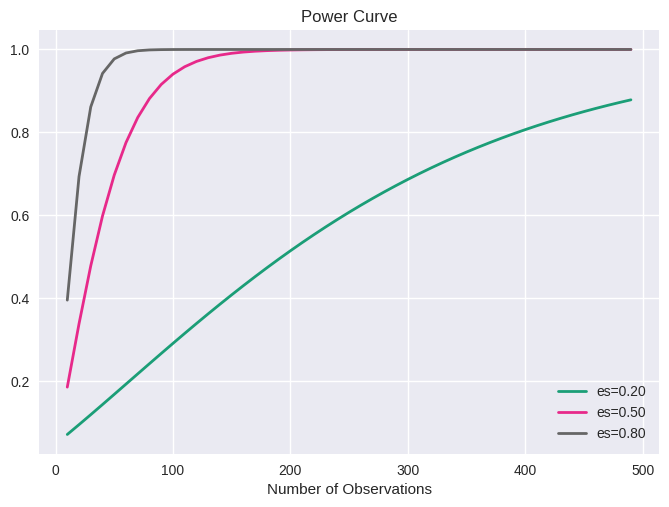

In [243]:
# plot power curves
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(10, 500, 10))

plt.style.use('seaborn')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig = power_analysis.plot_power(
    dep_var='nobs', nobs=sample_sizes,  
    effect_size=effect_sizes, alpha=0.05, ax=ax, 
    title='Power Curve')

## ANCOVA

### ANCOVA #1: ObjectId ~ Booked * Perceived_Race

In [244]:
homogeneity_test = "ObjectId ~ Booked * Perceived_Race"
model_test = smf.ols(homogeneity_test, data=aggsub).fit()
print(model_test.summary())

                            OLS Regression Results                            
Dep. Variable:               ObjectId   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1545.
Date:                Sun, 16 Apr 2023   Prob (F-statistic):           4.65e-59
Time:                        18:48:25   Log-Likelihood:                -340.99
No. Observations:                  64   AIC:                             714.0
Df Residuals:                      48   BIC:                             748.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

The table shows the coefficient estimates for each variable, the standard error, the t-statistic, and the p-value. The R-squared value of the model is 0.998, indicating a strong fit. The p-values for the variables indicate whether they are statistically significant at the 0.05 level. 

To check the homogenity, we check if the relationship between total arrests and total number of booked strip search is the same across all races. We examine the interaction term of Number of bookings and races, the interaction term generates slopes. Note that the p-values for all interaction terms are above the benchhmark 0.05, thus the slopes does not significantly differ from all races, which meets the assumption of homogeinity. 

In [245]:
#ANCOVA
race_dum = pd.get_dummies(aggsub['Perceived_Race'], drop_first=True)
race_dum.columns = race_dum.columns.str.replace(' ', '_').str.replace('/', '_').str.replace('-', '_')
racesub = pd.concat([aggsub, race_dum], axis=1)

formula = "ObjectId ~ Booked + East_Southeast_Asian + Indigenous + Latino + Middle_Eastern + South_Asian + Unknown_or_Legacy + White"
ancovam = smf.ols(formula, data=racesub).fit()
print(ancovam.summary())
table_data = []
for col, coef, std_err, z, p, ci_low, ci_high in zip(ancovam.params.index, ancovam.params, ancovam.bse, ancovam.tvalues, ancovam.pvalues, ancovam.conf_int()[0], ancovam.conf_int()[1]):
    table_data.append([col, coef, std_err, z, p, ci_low, ci_high])

headers = ['Variable', 'Coefficient', 'Std. Error', 'z', 'P>|z|', '[0.025', '0.975]']
title = "Model Summary of ObjectId ~ Booked + Perceived Race"
table_length = len(headers) * 15 + 1
title_spaces = (table_length - len(title)) // 2
ctitle = " " * title_spaces + title + " " * title_spaces
print(ctitle)
print(tabulate(table_data, headers=headers, tablefmt='fancy_grid'))


                            OLS Regression Results                            
Dep. Variable:               ObjectId   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3173.
Date:                Sun, 16 Apr 2023   Prob (F-statistic):           2.17e-70
Time:                        18:48:25   Log-Likelihood:                -342.42
No. Observations:                  64   AIC:                             702.8
Df Residuals:                      55   BIC:                             722.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              624.0008 

Note that the adjusted R-square is 0.998 which means our model fits the data well and the model explains 99.8% of the variability of the predictive variable, total number of arrests. Also, the p-value for all explanatory variables is smaller than the threshold of 0.05, thus all variables are significant predictors. Holding all other variables constant, for every 1 unit increase in the book, the total arrests increases by 1.28. Black is a reference group of the model, holding other variables constant, East/Southeast Asian group is 410.20 units of total arrests lower, the Indigenous group is 556.81 units of total arrests lower, the Latino group is 559.09 units of total arrests lower, Mid-Eastern group is 482.91 units of total arrests lower, South Asian group is 458.62 units of total arrests lower, Unknown or Legacy group is 387.96 units of total arrests lower, White group is 524.65 units of total arrests higher, than the Black group on average.


In [246]:
fitted_values = ancovam.fittedvalues
residuals = ancovam.resid

_, pval, _, _ = het_breuschpagan(residuals, racesub[['Booked', 'East_Southeast_Asian', 'Indigenous', 'Latino', 'Middle_Eastern', 'South_Asian', 'Unknown_or_Legacy', 'White']])

print("Breusch-Pagan test p-value:", pval)


Breusch-Pagan test p-value: 6.295056454374421e-06


To check if the variance of residual is equal across all races, we use Breusch-Pagan test after building the ANCOVA model. The p-value is smaller than 0.05, indicates the model fails homoscedasticity assumption.

In [247]:
#check residuals normality
residuals = ancovam.resid
shapiro_stat, shapiro_pval = stats.shapiro(residuals)
print("Shapiro-Wilk test p-value:", shapiro_pval)

Shapiro-Wilk test p-value: 0.01819002628326416


The p-value of Shapiro-Wilk tests indicates the residuals are not normally distributed as the p-value of the test is 0.02< 0.05. However, this might due to the over sensitive of the test as our smaple size is larger than 50.

### ANCOVA #2: ObjectId ~ Booked + Sex

In [248]:
aggsubs=sub.groupby(['Arrest_Year','Arrest_Month','Sex']).agg({'ObjectId': 'count','Booked': 'sum'}).reset_index()
print(aggsubs)
aggsubs = pd.get_dummies(aggsubs, columns=['Sex'], prefix='Sex')

    Arrest_Year Arrest_Month Sex  ObjectId  Booked
0          2020     Apr-June   F      1172     520
1          2020     Apr-June   M      5615    2950
2          2020     Apr-June   U         1       0
3          2020      Jan-Mar   F      2060     961
4          2020      Jan-Mar   M      7265    4367
5          2020    July-Sept   F      1522     734
6          2020    July-Sept   M      6673    3815
7          2020    July-Sept   U         1       0
8          2020      Oct-Dec   F      1309     579
9          2020      Oct-Dec   M      5899    3165
10         2020      Oct-Dec   U         4       1
11         2021     Apr-June   F      1619     671
12         2021     Apr-June   M      6616    3467
13         2021     Apr-June   U         1       0
14         2021      Jan-Mar   F      1572     673
15         2021      Jan-Mar   M      6491    3434
16         2021    July-Sept   F      1631     664
17         2021    July-Sept   M      6803    3693
18         2021    July-Sept   

In [249]:

homogeneity_test = "ObjectId ~ Booked * Sex_F + Booked * Sex_M+Booked*Sex_U"
model_test = smf.ols(homogeneity_test, data=aggsubs).fit()
print(model_test.summary())

                            OLS Regression Results                            
Dep. Variable:               ObjectId   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1485.
Date:                Sun, 16 Apr 2023   Prob (F-statistic):           1.18e-19
Time:                        18:48:25   Log-Likelihood:                -131.17
No. Observations:                  21   AIC:                             274.3
Df Residuals:                      15   BIC:                             280.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      690.2914    139.942      4.933   

The table shows the coefficient estimates for each variable, the standard error, the t-statistic, and the p-value. The R-squared value of the model is 0.997, indicating a strong fit. The p-values for the variables indicate whether they are statistically significant at the 0.05 level.

To check the homogenity, we check if the relationship between total arrests and total number of booked strip search is the same across all gender. We examine the interaction term of Number of bookings and gender, the interaction term generates slopes. Note that the p-values for interaction terms are above the benchhmark 0.05, thus the slopes don't  significantly differ from all races, which meet the assumption of homogeinity.

In [250]:
# Define the formulas for the OLS model
formulas = "ObjectId ~ Booked + Sex_F + Sex_M + Sex_U"
# Fit the OLS model to the aggregated data using the defined formulas
ancovams = smf.ols(formulas, data=aggsubs).fit()

print(ancovams.summary())

# Create an empty list to store the table data
table_data = []
for col, coef, std_err, z, p, ci_low, ci_high in zip(ancovam.params.index, ancovam.params, ancovam.bse, ancovam.tvalues, ancovam.pvalues, ancovam.conf_int()[0], ancovam.conf_int()[1]):
    table_data.append([col, coef, std_err, z, p, ci_low, ci_high])

# Define the headers for the table
headers = ['Variable', 'Coefficient', 'Std. Error', 'z', 'P>|z|', '[0.025', '0.975]']
# Define the title for the table and center it
title = "Model Summary of ObjectId ~ Booked + Sex"
table_length = len(headers) * 13 + 1
title_spaces = (table_length - len(title)) // 2
ctitle = " " * title_spaces + title + " " * title_spaces
print(ctitle)
print(tabulate(table_data, headers=headers, tablefmt='fancy_grid'))


                            OLS Regression Results                            
Dep. Variable:               ObjectId   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2341.
Date:                Sun, 16 Apr 2023   Prob (F-statistic):           1.95e-22
Time:                        18:48:25   Log-Likelihood:                -133.07
No. Observations:                  21   AIC:                             274.1
Df Residuals:                      17   BIC:                             278.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    754.6043    137.999      5.468      0.0

Note that the adjusted R-square is 0.997 which means the our model fits the data well and the model explaines 99.7% of the variability of the predictive variable, total number of arrests. Also, the p-value for all exaplainatory variables are smaller than 0.05, thus gender a significant predictor. Holding all other variables constant, every 1 unit increase in booked, the total arrests increases by 1.19. Female is a reference group of the model, holding other variables constant, male is 1531.18 units of total arrests higher, unknown is 741.63 units of total arrests lower,than the female group on average.

In [251]:
# Calculate the fitted values and residuals for the OLS model
fitted_values = ancovams.fittedvalues
residuals = ancovams.resid
# Use the 'het_breuschpagan' function from the 'statsmodels.stats.diagnostic' library to perform the Breusch-Pagan test of heteroscedasticity
# The test takes the residuals as the first argument, and the regressors (Booked, Sex_F, Sex_M, and Sex_U) as the second argument
_, pval, _, _ = het_breuschpagan(residuals, aggsubs[['Booked','Sex_F', 'Sex_M', 'Sex_U']])

print("Breusch-Pagan test p-value:", pval)

Breusch-Pagan test p-value: 0.01884206238652575


To check if the variance of residual is equal across all races, we use Breusch-Pagan test after building the ANCOVA model. The p-value is smaller than 0.05, indicates the model fails homoscedasticity assumption.

In [252]:
#check residuals normality
residuals = ancovams.resid
shapiro_stat, shapiro_pval = stats.shapiro(residuals)
print("Shapiro-Wilk test p-value:", shapiro_pval)

Shapiro-Wilk test p-value: 0.5671059489250183


The p-value of Shapiro-Wilk tests indicates the residuals are normally distributed as the p-value of the test is 0.56> 0.05. 

## Logistic Regression

### Logistic Regression 1: Predict Actions_at_arrest___Cooperative

In [253]:
# create dummy variables for the object columns
dummy=pd.get_dummies(df.select_dtypes(object))
dummy.head()

,Arrest_Month_Apr-June,Arrest_Month_Jan-Mar,Arrest_Month_July-Sept,Arrest_Month_Oct-Dec,Perceived_Race_Black,Perceived_Race_East/Southeast Asian,Perceived_Race_Indigenous,Perceived_Race_Latino,Perceived_Race_Middle-Eastern,Perceived_Race_South Asian,...,Occurrence_Category_harassment,Occurrence_Category_impaired,Occurrence_Category_mischief,Occurrence_Category_other,Occurrence_Category_police,Occurrence_Category_robbery,Occurrence_Category_sexual and children,Occurrence_Category_vehicle,Occurrence_Category_warrant,Occurrence_Category_weapons and homicide
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [254]:
# Select the columns of interest from the dummy DataFrame
X = dummy[['ArrestLocDiv_31', 'Occurrence_Category_other', 'ArrestLocDiv_51']]
y = df.Actions_at_arrest___Cooperative
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023)

<Axes: >

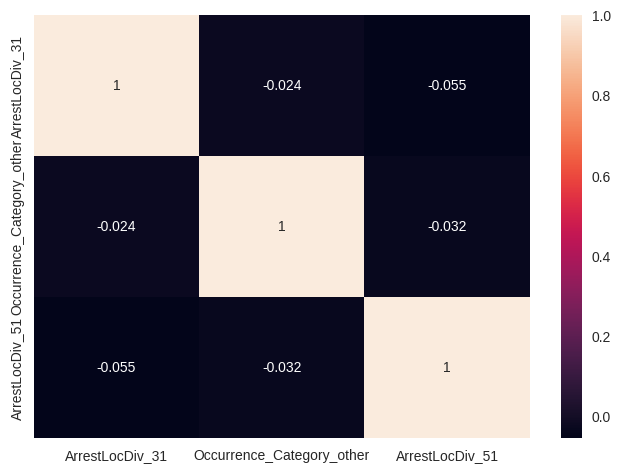

In [255]:
# plot a heatmap of the correlation matrix
sns.heatmap(X.corr(), annot=True)

The heatmap data indicates that the correlation between the three variables (ArrestLocDiv_31, Occurrence_Category_other, and ArrestLocDiv_51) is very low, with correlation coefficients ranging from -0.055 to 0.024, suggesting a weak linear relationship between them. This suggests that these three variables can be used as separate independent variables in logistic regression analysis without causing multicollinearity issues.

In [256]:
# Create a logistic regression model
lr = LogisticRegressionCV()

# Fit the logistic regression model to the training data
lr.fit(X, y)

# Print a classification report for the model's predictions
print(classification_report(lr.predict(X), y))


              precision    recall  f1-score   support

           0       0.98      0.56      0.71     62352
           1       0.05      0.66      0.10      2263

    accuracy                           0.56     64615
   macro avg       0.52      0.61      0.40     64615
weighted avg       0.95      0.56      0.69     64615



In [257]:
print(confusion_matrix(lr.predict(X), y))

[[34815 27537]
 [  762  1501]]


This shows the resulting confusion matrix, with the numbers of true positives, true negatives, false positives, and false negatives. Specifically, there were 34,815 true negatives (predicted not cooperative and actually not cooperative), indicating that the model correctly predicted that the person would not cooperate in these cases. Additionally, there were 1,501 true positives (predicted cooperative and actually cooperative), indicating that the model correctly predicted that the person would cooperate in these cases. However, there were also 27,537 false positives (predicted cooperative but actually not cooperative), which means that the model incorrectly predicted that the person would cooperate in these cases. Finally, there were 762 false positives (predicted not cooperative but actually cooperative), which means that the model incorrectly predicted that the person would not cooperate in these cases.


In [258]:
# Concatenate the 'X' and 'y' DataFrames along the columns axis to create a new DataFrame 'data'
data = pd.concat(objs=[X, y], axis=1)
# fit a logistic regression model to the data
log_reg = smf.logit(
    "Actions_at_arrest___Cooperative ~ ArrestLocDiv_31 + Occurrence_Category_other + ArrestLocDiv_51",
    data=data).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.682343
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Logit Regression Results                                 
===========================================================================================
Dep. Variable:     Actions_at_arrest___Cooperative   No. Observations:                64615
Model:                                       Logit   Df Residuals:                    64611
Method:                                        MLE   Df Model:                            3
Date:                             Sun, 16 Apr 2023   Pseudo R-squ.:                0.008248
Time:                                     18:48:28   Log-Likelihood:                -44090.
converged:                                    True   LL-Null:                       -44456.
Covariance Type:                         nonrobust   LLR p-value:                1.207e-158
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.1753      0.009    -20.007      0.000      -0.192      -0.158
ArrestLocDiv_31               0.8740      0.045     19.285      0.000       0.785       0.963
Occurrence_Category_other    -0.4021      0.029    -13.665      0.000      -0.460      -0.344
ArrestLocDiv_51              -0.3256      0.030    -10.708      0.000      -0.385      -0.266
=============================================================================================
"""

Compared with arrested people who were not arrested at ArrestLocDiv_31, the log odds of getting the arrested people to be cooperative during the arrest at ArrestLocDiv_31 are 0.874 higher, controlling for other features. Note this feature is statistically significant. The coefficient for ArrestLocDiv_51 is -0.3256, indicating that compared with arrested people who were not arrested at ArrestLocDiv_51, the log odds of getting the arrested people to be cooperative during the arrest at ArrestLocDiv_51 are 0.3256 lower, controlling for other features. Again, the feature is statistically significant. The coefficient for Occurrence_Category_other is -0.4021, indicating that when compared to other reasons for arrest that are not categorized under Occurrence_Category_other, the log odds of arrested individuals being cooperative during the arrest for reasons falling under Occurrence_Category_other are 0.4021 lower. It is important to note that this feature is statistically significant.

In [259]:
# display the odds ratio
odds_ratios = pd.DataFrame({
    "OR": log_reg.params,
    "Lower CI": log_reg.conf_int()[0],
    "Upper CI": log_reg.conf_int()[1],
})
odds_ratios = np.exp(odds_ratios)

print(odds_ratios)

                                 OR  Lower CI  Upper CI
Intercept                  0.839239  0.824953  0.853772
ArrestLocDiv_31            2.396433  2.192756  2.619029
Occurrence_Category_other  0.668885  0.631396  0.708600
ArrestLocDiv_51            0.722074  0.680296  0.766417


The values in the second column represent the odds ratios for each predictor variable. The odds ratio for ArrestLocDiv_31 is 2.396433, indicating that individuals arrested at ArrestLocDiv_31 are more likely to exhibit cooperative behaviour during the arrest compared to those who were not arrested there. On the other hand, the odds ratio for Occurrence_Category_other is 0.668885, suggesting that individuals arrested for reasons falling under Occurrence_Category_other are less likely to exhibit cooperative behaviour during the arrest compared to those arrested for other reasons. Similarly, the odds ratio for ArrestLocDiv_51 is 0.722074, which means that individuals arrested at ArrestLocDiv_51 are also less likely to exhibit cooperative behaviour during the arrest compared to those who were not arrested there. The confidence intervals for all three odds ratios do not include 1, indicating that these associations are statistically significant.

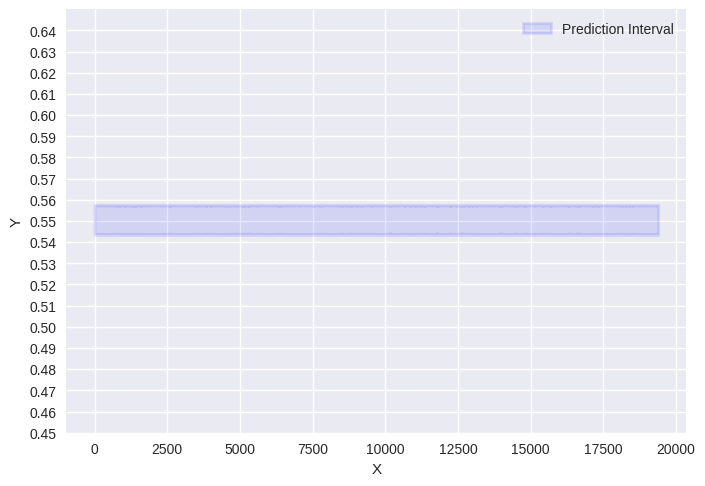

In [260]:

# Calculate the predicted probabilities
y_pred = lr.predict_proba(X_test)[:, 0]

# Calculate the mean and standard deviation of the predicted probabilities
y_mean = np.mean(y_pred)
se = np.sqrt((y_pred * (1 - y_pred)) / len(y_pred))
y_std = se * 1.96

# Plot the prediction interval
plt.fill_between(range(len(y_pred)),
                 y_mean - y_std,
                 y_mean + y_std,
                 alpha=.1,
                 color='blue',
                 label='Prediction Interval',
                 linewidth=2)
plt.ylim(0.45, 0.65)
plt.yticks(np.arange(0.45, 0.65, 0.01))
plt.legend(),
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

This is the prediction interval for our first logistic regression model. The shaded region represents the range of values where we expect the true probability of the outcome variable to lie with 95% confidence. The x-axis of the plot represents the index number of the data points in the test dataset, while the y-axis represents the probability of the model's predictions. Based on the plot, we can see that the model's predicted results mostly fall around 0.55, and the confidence interval is relatively stable, indicating that the model's predicted results are relatively accurate.

Optimization terminated successfully.
         Current function value: 0.685587
         Iterations 4


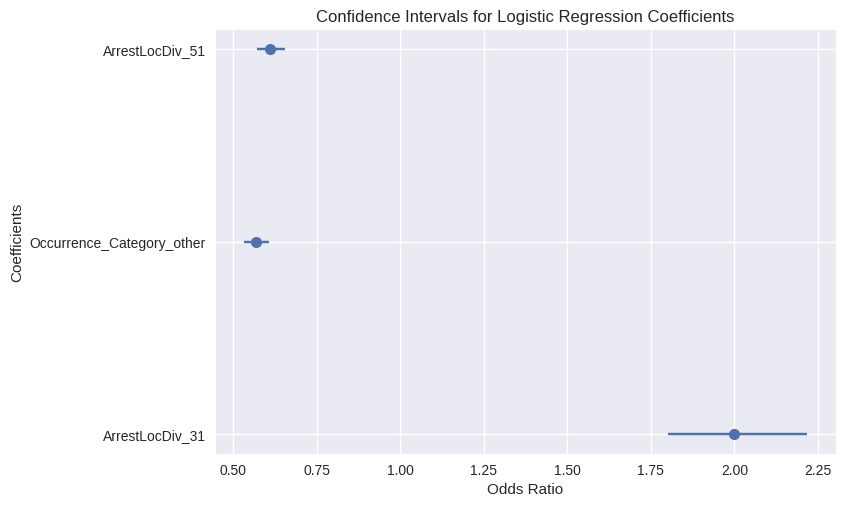

In [261]:
# fit model
logit_model = sm.Logit(y_train, X_train)
logit_result = logit_model.fit(alpha=0.05)

# calculation
conf_int = logit_result.conf_int()
conf_int.columns = ['Lower CI', 'Upper CI']
conf_int['OR'] = logit_result.params
conf_int = np.exp(conf_int)
conf_int = conf_int[['Lower CI', 'Upper CI', 'OR']]

# CI
fig, ax = plt.subplots()
ax.errorbar(conf_int['OR'],
            conf_int.index,
            xerr=(conf_int['OR'] - conf_int['Lower CI'],
                  conf_int['Upper CI'] - conf_int['OR']),
            fmt='o',
            markersize=8,
            capsize=5)
ax.set_xlabel('Odds Ratio')
ax.set_ylabel('Coefficients')
ax.set_title('Confidence Intervals for Logistic Regression Coefficients')
plt.show()

The plot shows the odds ratios and confidence intervals for the coefficients of our first logistic regression model. The points on the plot represent the estimated odds ratios for each predictor variable, and the error bars represent the 95% confidence intervals around these estimates. If the error bar does not cross the value of 1 on the horizontal axis, it suggests that the odds ratio estimate is statistically significant at the 95% confidence level. A value of 1 for the odds ratio indicates that the predictor variable has no effect on the outcome variable. In this plot, we can see that the odds ratio estimates for all predictor variables are statistically significant, as their error bars do not cross the value of 1. For example, the odds ratio estimate for ArrestLocDic_31 is 2, and its confidence interval [1.8, 2.2] does not include 1.

###Logistic Regression 2： Booked~Actions_at_arrest_Cooperative+Perceived_Race

In [262]:
sub2 = df[['Perceived_Race', 'Booked','Actions_at_arrest___Cooperative']]

sub2 = pd.get_dummies(sub2, columns=['Perceived_Race'])

# Split the data into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(sub2[['Actions_at_arrest___Cooperative', 'Perceived_Race_Black', 'Perceived_Race_Indigenous', 'Perceived_Race_Latino', 'Perceived_Race_South Asian', 'Perceived_Race_Unknown or Legacy', 'Perceived_Race_White']], sub2['Booked'], test_size=0.3, random_state=2178)
model2 = LogisticRegression()
model2.fit(X2_train, y2_train)

coef = np.squeeze(model2.coef_)
# Compute the standard errors of the coefficient estimates
se = np.sqrt(np.diag(np.linalg.inv(np.dot(X2_train.T, X2_train))))
# Compute the z-scores
z = coef / se
# Compute the two-tailed p-values
p = 2 * (1 - stats.norm.cdf(np.abs(z)))

# Compute the 95% confidence intervals
ci_low = coef - 1.96 * se
ci_high = coef + 1.96 * se
print('Coefficient Estimates:\n', coef)
print('Intercept:\n', model2.intercept_)
print('Standard Errors:\n', se)
print('Z-Scores:\n', z)
print('P-Values:\n', p)
print('95% Confidence Intervals:\n', np.column_stack((ci_low, ci_high)))



Coefficient Estimates:
 [ 0.19242055  0.2687146   0.30104031  0.28540087  0.0239326  -0.02367078
  0.1224254 ]
Intercept:
 [-0.13127674]
Standard Errors:
 [0.00896714 0.00987393 0.02775321 0.02916112 0.02024688 0.01726812
 0.00824367]
Z-Scores:
 [21.45841787 27.21455295 10.8470457   9.78703514  1.18203878 -1.3707794
 14.85084549]
P-Values:
 [0.         0.         0.         0.         0.23719032 0.17044373
 0.        ]
95% Confidence Intervals:
 [[ 0.17484496  0.20999614]
 [ 0.24936169  0.2880675 ]
 [ 0.24664403  0.3554366 ]
 [ 0.22824508  0.34255666]
 [-0.01575129  0.06361649]
 [-0.05751629  0.01017473]
 [ 0.10626782  0.13858299]]


In [263]:
# DataFrame object containing the coefficient estimates of the logistic regression model fitted to the X2_train and y2_train data
coef_df = pd.DataFrame({'Predictor Variable': X2_train.columns, 'Coefficient Estimate': model2.coef_.flatten()})
print(coef_df)

                 Predictor Variable  Coefficient Estimate
0   Actions_at_arrest___Cooperative              0.192421
1              Perceived_Race_Black              0.268715
2         Perceived_Race_Indigenous              0.301040
3             Perceived_Race_Latino              0.285401
4        Perceived_Race_South Asian              0.023933
5  Perceived_Race_Unknown or Legacy             -0.023671
6              Perceived_Race_White              0.122425


The above is the summary of the second logistic regression model. The intercept term in the Logit Regression Results table represents the estimated log odds of the outcome variable when all predictor variables are equal to zero, which is -0.13. Holding all other variables constant, for each unit increase in cooperative action, the log odds of being booked for a strip search increased by 0.19. Holding all other variables constant, Black, Indigenous, Latino, South Asian and White dependents have higher log odds of being booked, while the Unknown group has a lower log odds of being booked, compared to the reference group, Middle-eastern. Among all the groups, the South Asian and Unknown groups have a p-value that is above the threshold of 0.05, indicating their coefficient estimate is not statistically significant.

In [264]:
# print accuracy
accuracy = model2.score(X2_test, y2_test)
print('Accuracy:', accuracy)

Accuracy: 0.535981428939902


Noted that the accuracy of our second logistic regression model is 0.54.

In [265]:
# print confusion matrix
y2_pred = model2.predict(X2_test)
cm2 = confusion_matrix(y2_test, y2_pred)
print('Confusion Matrix:')
print(cm2)

Confusion Matrix:
[[3595 5589]
 [3406 6795]]


We used a confusion matrix to evaluate how well our model performed in predicting whether an individual would be booked for a strip search, based on their race and actions at arrest. The results of the confusion matrix are shown in Table 13, which shows the number of true positives, true negatives, false positives, and false negatives. In particular, the confusion matrix indicates that the model correctly predicted 3,595 cases as true negatives, where the person wasn’t booked for a strip search and the model predicted that they indeed weren’t booked. Additionally, there were 6,795 cases where the model correctly predicted that the person was booked for a strip search (true positives). However, there were also 5,589 cases where the model incorrectly predicted that the person was booked for a strip search (false positives). Finally, the model incorrectly predicted that the person wasn’t booked for a strip search in 3,406 cases (false negatives).

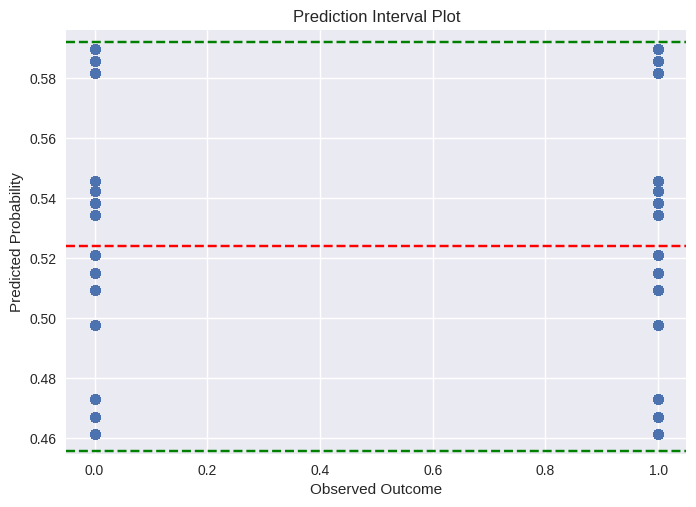

In [266]:
y2_pred_proba = model2.predict_proba(X2_test)[:,1]

# Create a prediction interval plot
plt.scatter(y2_test, y2_pred_proba)
plt.axhline(y=np.mean(y2_pred_proba), color='r', linestyle='--')
plt.axhline(y=np.mean(y2_pred_proba) + 1.96 * np.std(y2_pred_proba), color='g', linestyle='--')
plt.axhline(y=np.mean(y2_pred_proba) - 1.96 * np.std(y2_pred_proba), color='g', linestyle='--')
plt.xlabel('Observed Outcome')
plt.ylabel('Predicted Probability')
plt.title('Prediction Interval Plot')
plt.show()



The red dashed line serves as a reference line at the mean predicted probability while the two green dashed lines indicate the upper and lower bounds of a 95% prediction interval. The interval is calculated as the mean predicted probability plus or minus 1.96 times the standard deviation of the predicted probabilities. The above plot helps visualizes how well the model predictions match the observed outcomes. Noted that the points are widely spread out, which suggests the model’s predictions are less reliable and the prediction interval might be widened.

In [267]:
# Extract the coefficient estimates from the logistic regression model
coef = np.squeeze(model2.coef_)
# Calculate the odds ratios
odds_ratio = np.exp(coef)

# Compute the standard errors of the coefficient estimates
se = np.sqrt(np.diag(np.linalg.inv(np.dot(X2_train.T, X2_train))))
# Compute the z-scores
z = coef / se
p = 2 * (1 - stats.norm.cdf(np.abs(z)))
# Compute the 95% confidence intervals
ci_low = np.exp(coef - 1.96 * se)
ci_high = np.exp(coef + 1.96 * se)

print('Coefficient Estimates:\n', coef)
print('Odds Ratios:\n', odds_ratio)
print('Intercept:\n', model2.intercept_)
print('Standard Errors:\n', se)
print('Z-Scores:\n', z)
print('P-Values:\n', p)
print('95% Confidence Intervals:\n', np.column_stack((ci_low, ci_high)))

Coefficient Estimates:
 [ 0.19242055  0.2687146   0.30104031  0.28540087  0.0239326  -0.02367078
  0.1224254 ]
Odds Ratios:
 [1.21218019 1.3082817  1.35126382 1.3302952  1.02422128 0.97660718
 1.13023481]
Intercept:
 [-0.13127674]
Standard Errors:
 [0.00896714 0.00987393 0.02775321 0.02916112 0.02024688 0.01726812
 0.00824367]
Z-Scores:
 [21.45841787 27.21455295 10.8470457   9.78703514  1.18203878 -1.3707794
 14.85084549]
P-Values:
 [0.         0.         0.         0.         0.23719032 0.17044373
 0.        ]
95% Confidence Intervals:
 [[1.19106155 1.2336733 ]
 [1.28320608 1.33384734]
 [1.27972348 1.42680346]
 [1.25639321 1.40854416]
 [0.98437211 1.06568362]
 [0.94410651 1.01022667]
 [1.11211968 1.148645  ]]


All VIF are less then 10, the assumption of no multicollinearity met. 

In [268]:
# check multicollinearity by VIF
var = sub2.drop("Booked", axis=1)
var["Intercept"] = 1

vif = pd.DataFrame()
vif["Predictive Variable"] = var.columns
vif["VIF"] = [variance_inflation_factor(var.values, i) for i in range(var.shape[1])]

print(vif)

                   Predictive Variable       VIF
0      Actions_at_arrest___Cooperative  1.002526
1                 Perceived_Race_Black       inf
2  Perceived_Race_East/Southeast Asian       inf
3            Perceived_Race_Indigenous       inf
4                Perceived_Race_Latino       inf
5        Perceived_Race_Middle-Eastern       inf
6           Perceived_Race_South Asian       inf
7     Perceived_Race_Unknown or Legacy       inf
8                 Perceived_Race_White       inf
9                            Intercept  0.000000


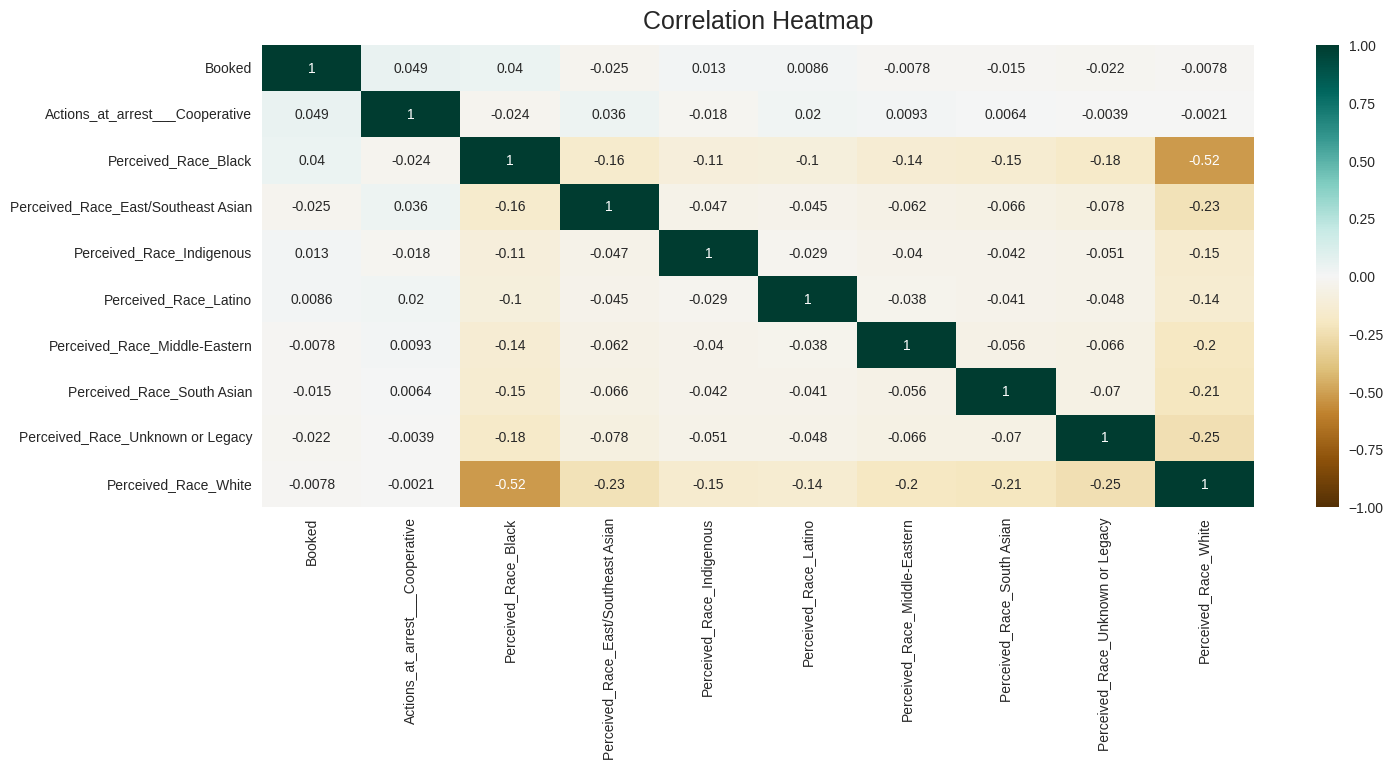

In [269]:
# creat a heatmap
corr_matrix = sub2.corr()
plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix, vmin=-1, vmax=1,annot=True, cmap="BrBG").set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.show()

The heatmap data indicates that the correlation between the perceived races and booked is very low, with correlation coefficients ranging from -0.525 to 0.049, suggesting a weak linear relationship between them. This suggests that these variables can be used as separate independent variables in logistic regression analysis without causing multicollinearity issues.

The model explains a small proportion of the predicted variable Booked. When the person is cooperative at arrest, the log-odds of being booked increases, compared to when the person is not cooperative. There is no significant difference in log-odds of being booked between Indigenous, Latino and Black.
The log-odds of being booked for South-Asian, Middle-Eastern, Unkown and White is lower than Black.